In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from scipy.special import sph_harm


from klap import (
    rbf_kernel,
    rbf_laplacian,
    exp_kernel,
    exp_laplacian
)
from klap.datasets import (
    meshgrid_3d
)


np.random.seed(100)

In [2]:
n = 10000
p = 500

# Learn spherical harmonics
x = np.random.randn(n, 3)
x /= np.sqrt(np.sum(x**2, axis=1))[:, np.newaxis]
X, Y, Z = meshgrid_3d(100)
x_repr = x[:p]

sigma = 10
kernel = exp_kernel

K = kernel(x_repr, x, sigma=sigma)
L = exp_laplacian(x_repr, x, sigma=sigma, K=K)
R = K @ K.T
L /= n
R /= n

In [3]:
error = eigh(L, eigvals_only=True, subset_by_index=[0,0])[0]
if error < 0:
    reg = -error * 1.1
if error > 0:
    reg = 1e-7
reg = 1e-3
w, v = eigh(R, L + reg * np.eye(len(L)), subset_by_index=[len(L)-16, len(L)-1])

In [4]:
x_test = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
k_test = kernel(x_test, x_repr, sigma=sigma)
y_test = k_test @ v
# y_test /= np.sqrt(np.mean(y_test**2, axis=0))

In [5]:
# Helper functions
def plot_sphere(ax, X, Y, Z, f, **kwargs):
    f /= np.sqrt(np.mean(f**2, axis=0))
    cm = plt.get_cmap('RdBu')(f.reshape(*X.shape))
    ax.plot_surface(X, Y, Z, facecolors=cm, **kwargs)
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-0.8, 0.8])
    ax.set_zlim([-0.8, 0.8])
    ax.set_axis_off()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])


def get_true_harmonic(x_test, num):
    out = np.zeros((len(x), num))
    phi = np.arccos(x_test[:,2])
    theta = np.arctan2(x_test[:,1], x_test[:,0])
    i = 0
    for i in range(num):
        l = int(np.sqrt(i))
        m = i - l**2 - l
        out[:, i] = sph_harm(m, l, theta, phi)
    return out

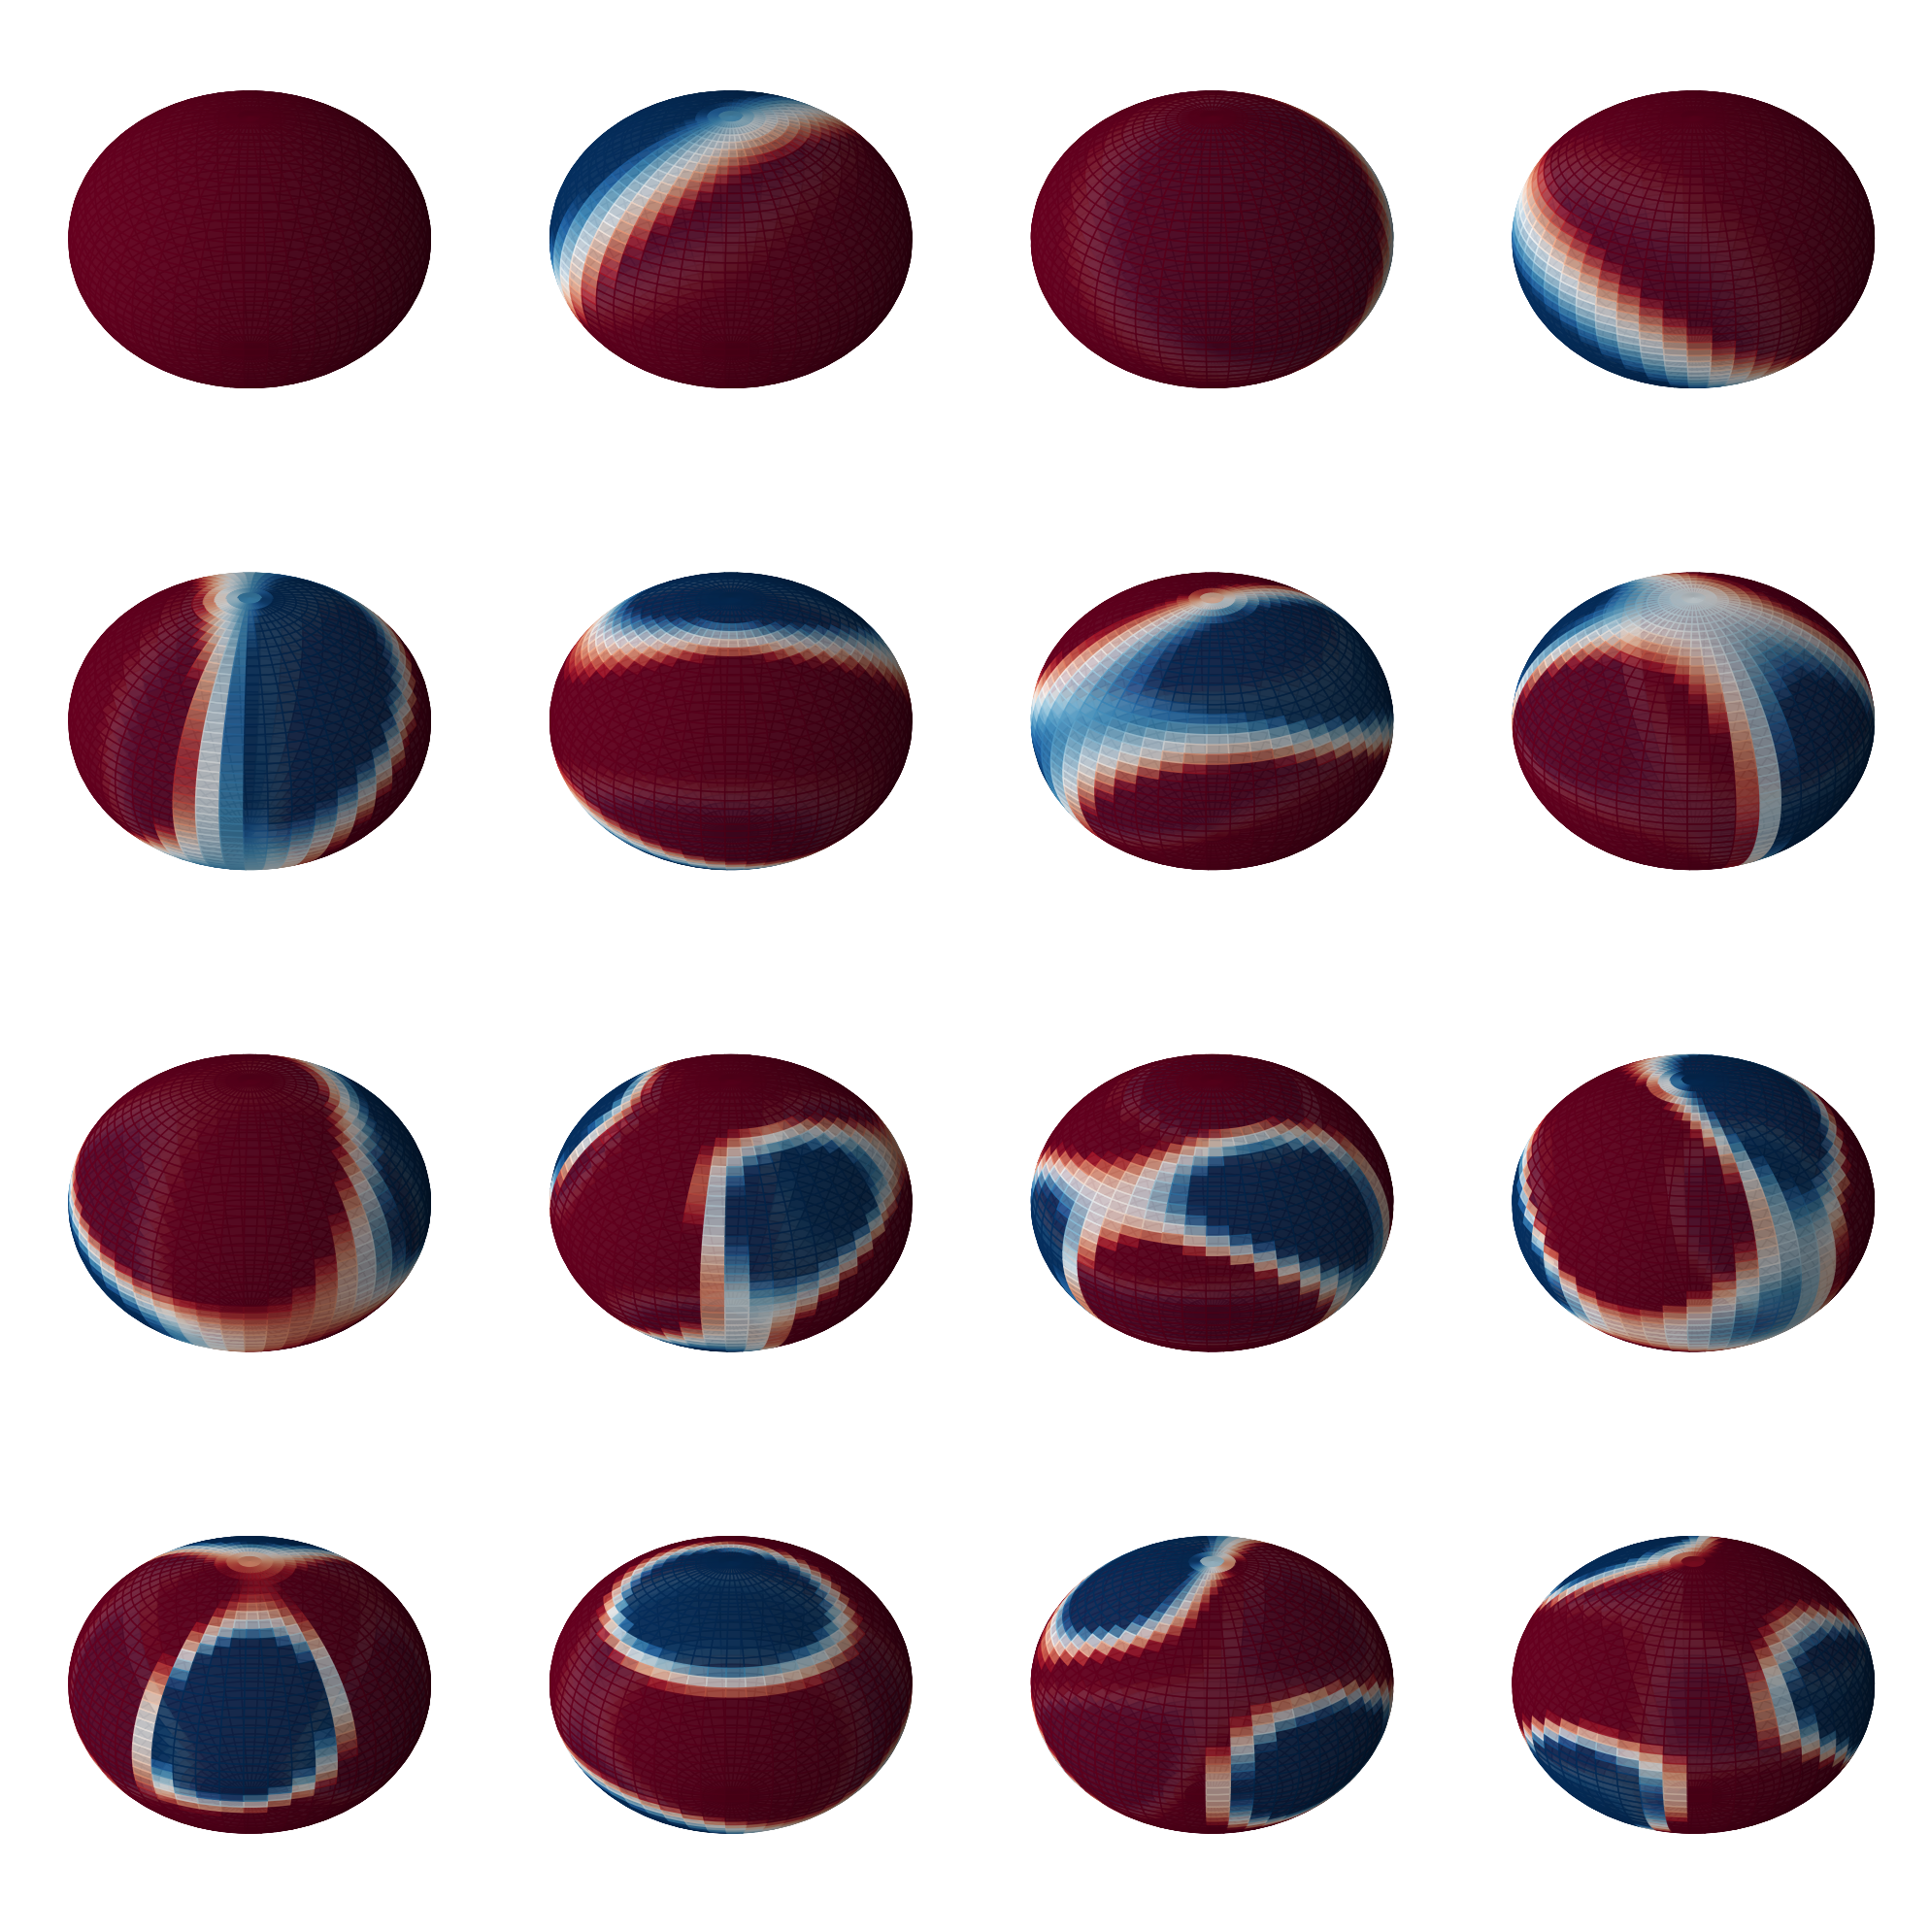

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), subplot_kw={"projection": "3d"})
for i in range(16):
    plot_sphere(axes[i//4, i%4], X, Y, Z, y_test[:, -i-1], alpha=.8)
    # axes[i//4, i%4].scatter(x[:, 0], x[:, 1], x[:, 2], alpha=1, s=10, c='k')
fig.tight_layout()
# fig.savefig('spherical_harmonics.jpg')

/tmp/ipykernel_62640/2687126525.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, i] = sph_harm(m, l, theta, phi)


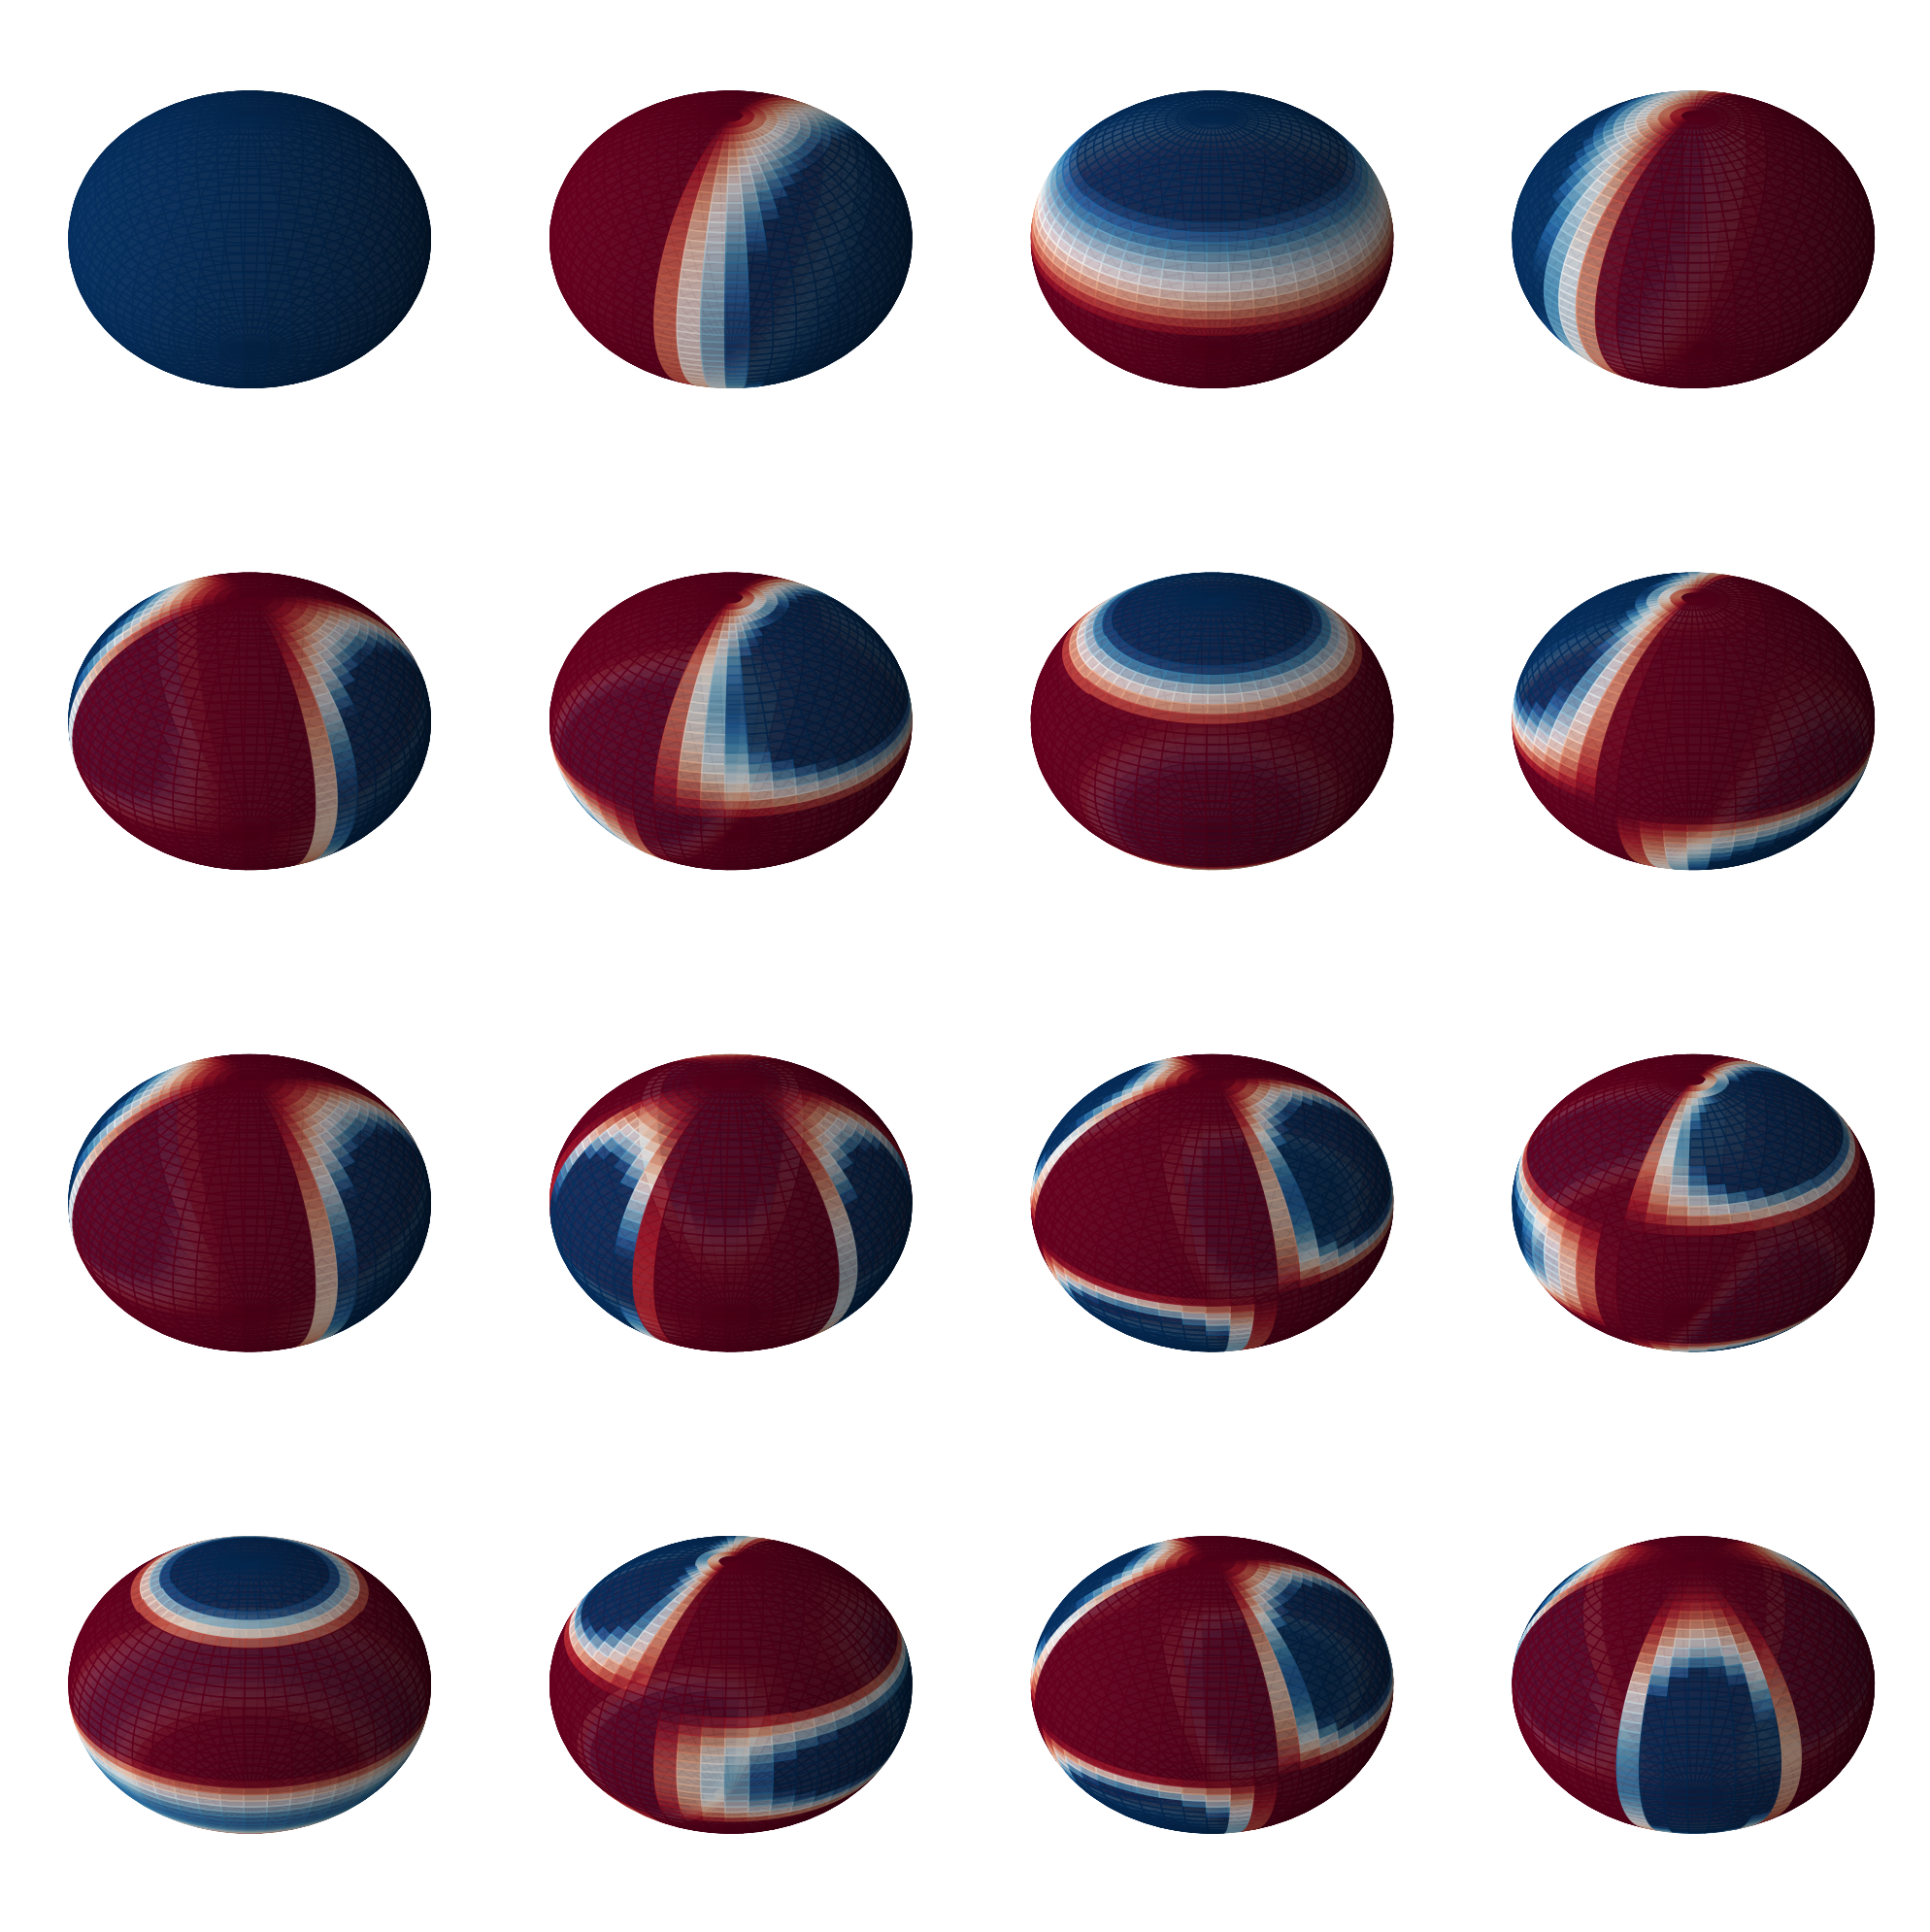

In [7]:
y_true = get_true_harmonic(x_test, 16)
fig, axes = plt.subplots(4, 4, figsize=(20, 20), subplot_kw={"projection": "3d"})
for i in range(16):
    plot_sphere(axes[i//4, i%4], X, Y, Z, y_true[:, i], alpha=.8)
fig.tight_layout()
# fig.savefig('true_harmonics.jpg')